# <center> CS 178: Machine Learning &amp; Data Mining </center>
## <center> Homework 5: Due Friday 2 December 2022 (11:59pm) </center>
### <center> Version 1.0 (Last Modified: 23 November 2022) </center>

---
## Instructions


This homework (and many subsequent ones) will involve data analysis and reporting on methods and results
using Python code. You will submit a **single PDF file** that contains everything to Gradescope. This includes any text you wish to include to describe your results, the complete code snippets of how you attempted each problem, any figures that were generated, and scans of any work on paper that you wish to include. It is important that you include enough detail that we know how you solved the problem, since otherwise we will be unable to grade it.


Your homeworks will be given to you as Jupyter notebooks containing the problem descriptions and some template code that will help you get started. You are encouraged to use these starter Jupyter notebooks to complete your assignment and to write your report. This will help you not only ensure that all of the code for the solutions is included, but also will provide an easy way to export your results to a PDF file (for example, doing *print preview* and *printing to pdf*). I recommend liberal use of Markdown cells to create headers for each problem and sub-problem, explaining your implementation/answers, and including any mathematical equations. For parts of the homework you do on paper, scan it in such that it is legible (there are a number of free Android/iOS scanning apps, if you do not have access to a scanner), and include it as an image in the Jupyter notebook.

If you have any questions/concerns about using Jupyter notebooks, ask us on EdD. If you decide not to use Jupyter notebooks, but go with Microsoft Word or Latex to create your PDF file, make sure that all of the answers can be generated from the code snippets included in the document.

### Summary of Assignment: 100 total points
- Problem 1: Implementing kMeans (65 points)
    - Problem 1.1: compute_membership (10 points)
    - Problem 1.2: initialize_clusters (20 points)
    - Problem 1.3: update_centroids (20 points)
    - Problem 1.4: fit (15 points)
- Problem 2: Experimenting with kMeans (30 points)
    - Problem 2.1: Varying k (10 points) 
    - Problem 2.2: Random initialization (10 points)
    - Problem 2.3: Kmeans++ initialization (10 points)
- Statement of Collaboration (5 points)

Before we get started, let's import some libraries that you will make use of in this assignment. Make sure that you run the code cell below in order to import these libraries.

**Important: In the code block below, we set `seed=1234`. This is to ensure your code has reproducible results and is important for grading. Do not change this. If you are not using the provided Jupyter notebook, make sure to also set the random seed as below.**

**Important: Do not change any codes we give you below, except for those waiting for you to complete. This is to ensure your code has reproducible results and is important for grading.**

In [166]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.inspection import DecisionBoundaryDisplay

# Fix the random seed for reproducibility
# !! Important !! : do not change this
seed = 1234
np.random.seed(seed)  

--- 
## Problem 1

In this problem you will implement the k-means clustering algorithm. Below, you are given some starter code which partially implements the class `KMeansClustering`, which defines a k-means clustering model. 

Let's also load in some data that we will use for the tests in Problem 1. Here, we are using the Iris dataset, where we're only using the first two features. Although you typically would split your data into a training set and a testing set, we won't do that here because we are only using this data to create some tests for your implementation.

In [167]:
# Load the Iris dataset
X, y = load_iris(return_X_y = True)
# Only use the first two features
X = X[:, :2]

In [168]:
class KMeansClustering:
    """ A class representing a k-means clustering algorithm.
    """
    
    def __init__(self, k, init_strategy, random_state=None):
        np.random.seed(random_state) # Sets the random seed of your implementation
        self.k = k  # Number of clusters
        self.centroids = None  # A numpy array containing the center of each cluster
        assert init_strategy in ['random', 'kmeans++'], 'Did not receive a valid initialization strategy.'
        self.init_strategy = init_strategy # The strategy that the algorithm will use to initialize centroids
        
    def compute_memberships(self, X, centroids):
        """ Given a feature matrix X and an array of centroids, 
            compute the cluster assignment for each datapoint in X.
            
        X: numpy array of shape (n, d) where n is the number of datapoints and d is the number of features
        centroids: numpy array of shape (k, d) where k is the number of clusters and d is the number of features
        
        Returns:
        which_cluster: numpy array of shape (n, ) containing the cluster assignment for each data point in X
        squared_distances: numpy array of shape (n, ) containing the squared distance between each data point in X
            and the centroid of its corresponding cluster
        """
        squared_distances = []
        which_cluster = []
        
        ### YOUR CODE STARTS HERE ###
        n = X.shape[0]

        which_cluster = np.empty((n, ), np.int64)
        squared_distances = np.empty((n, ), dtype=np.float64)

        for i in range(n):
            distance = np.power(X[i] - centroids, 2).sum(axis=1)
            which_cluster[i] = np.argmin(distance)
            squared_distances[i] = np.min(distance)
            
        ### YOUR CODE ENDS HERE ###
                  
        which_cluster = np.asarray(which_cluster)
        squared_distances = np.asarray(squared_distances)
        return which_cluster, squared_distances
        
    def initialize_clusters(self, X):
        """ Computes the initial clusters based on a feature matrix X.
        
        X: numpy array of shape (n, d) where n is the number of datapoints and d is the number of features
        
        Returns:
        centroids: numpy array of shape (k, d) where k is the number of clusters and d is the number of features,
            corresponding to the initial clusters chosen by the appropriate strategy
        """
        if self.init_strategy == 'random':
            
            rows = np.random.choice(X.shape[0], self.k, replace=False)
            centroids = X[rows]
            
            centroids = np.asarray(centroids) # Cast to numpy array
            return centroids
        
        elif self.init_strategy == 'kmeans++':
            n_rows = X.shape[0]
            centroids = np.empty((0, X.shape[1]))
                
            first_idx = np.random.choice(n_rows, 1)
            first_centroid = X[first_idx]
            
            centroids = np.append(centroids, first_centroid, axis=0)
                        
            for _ in range(self.k - 1):
                # Get distance^2 from each datapoint to nearest centroid 
                _, squared_distances = self.compute_memberships(X, centroids)
                # Turn into probability distrubtion
                probs = squared_distances / np.sum(squared_distances)
                # Sample a new centroid
                row = np.random.choice(n_rows, 1, p=probs)
                centroid = X[row]
                centroids = np.append(centroids, centroid, axis=0)
                    
            centroids = np.asarray(centroids) # Cast to numpy array
            return centroids
    
    def update_centroids(self, X, which_cluster):
        """ Updates the centroid locations based on a feature matrix X and cluster assignments which_cluster.
        
        X: numpy array of shape (n, d) where n is the number of datapoints and d is the number of features
        which_cluster: numpy array of shape (n, ) where n is the number of datapoints,
            corresponding to the cluster assignments of the datapoints in X
            
        Returns:
        centroids: numpy array of shape (k, d) where k is the number of clusters and d is the number of features,
            where each centroid corresponds to the mean of the feature vectors in the corresponding cluster.
        """
       
        ### YOUR CODE STARTS HERE ###
        centroids = np.empty((self.k, X.shape[1]))
        for i in range(self.k):
            centroid = np.mean(X[which_cluster == i], axis=0).reshape((1, 2))
            centroids[i] = centroid

        ### YOUR CODE ENDS HERE ###
    
        return centroids
        
    def fit(self, X, max_iter=100):
        """ Fits the k-means clustering algorithm.
        
        X: numpy array of shape (n, d) where n is the number of datapoints and d is the number of features,
            corresponding to our training data.
        """
        centroids =  self.initialize_clusters(X)
        which_cluster, _ = self.compute_memberships(X, centroids)
                
        converged = False
        i = 0  # Iteration counter
        while not converged:
            new_centroids = self.update_centroids(X, which_cluster)
            new_which_cluster, _ = self.compute_memberships(X, new_centroids)
            
            # We have reached convergence if the cluster assignments don't change,
            # or if we reach the maximum number of iterations.
            if np.array_equal(which_cluster, new_which_cluster):
                converged = True
            elif i == max_iter:
                converged = True
                
            centroids = new_centroids
            which_cluster = new_which_cluster
            i += 1
            
        self.centroids = centroids

### Problem 1.1 (10 points):

- Complete the function `compute_memberships`. This function should take in a feature matrix `X` and a numpy array `centroids` containing `k` centroids, i.e. the centers of our clusters. The function should return two things: (1) a numpy array containing the index of which centroid is closest to each datapoint in `X`, and (2) a numpy array containing the squared Euclidean distance to the nearest centroid for each point in `X`.
- Run the code block given below to test your implementation. If your code is correct, all tests should pass.

In [169]:
# Use this code block to test your implementation in Problem 1.1
# Don't change anything here -- just run it

kmeans = KMeansClustering(3, 'random', random_state=seed)
c = np.array([[4.5, 3.0], [5.5, 4.0]])
which_cluster, squared_distances = kmeans.compute_memberships(X[:5], c)
expected_centroid = np.array([1, 0, 0, 0, 1])
expected_sq_dist = np.array([0.41, 0.16, 0.08, 0.02, 0.41])
print(f'Test 1a passed: {np.array_equal(which_cluster, expected_centroid)}')
print(f'Test 1b passed: {np.allclose(squared_distances, expected_sq_dist, rtol=1e-4, atol=1e-4)}')

kmeans = KMeansClustering(3, 'random', random_state=seed)
c = np.array([[1.0, 10.0], [5.5, 4.0]])
which_cluster, squared_distances = kmeans.compute_memberships(X[:5], c)
expected_centroid = np.array([1, 1, 1, 1, 1])
expected_sq_dist = np.array([0.41, 1.36, 1.28, 1.62, 0.41])
print(f'Test 2a passed: {np.array_equal(which_cluster, expected_centroid)}')
print(f'Test 2b passed: {np.allclose(squared_distances, expected_sq_dist, rtol=1e-4, atol=1e-4)}')

Test 1a passed: True
Test 1b passed: True
Test 2a passed: True
Test 2b passed: True


### Problem 1.2 (20 points):

- Complete the function `initialize_clusters`. This function takes in a feature matrix `X` and returns a numpy array containing `k` initial centroids. You will implement two different strategies for initialization. Since this initialization is random, it is important that you closely follow the template code given above for this problem in order to make the tests pass.
- The first strategy is called `random`, where you will randomly choose `k` data points from the feature matrix `X`. Be careful not to choose the same datapoint twice! Hint: you may find the function `np.random.choice` helpful.
- The second strategy is called `kmeans++`. This strategy typically results in better clusters than the `random` strategy. In some more detail, `kmeans++` works as follows:
    1. Choose the first centroid as a random datapoint from your feature matrix $X$.
    2. For the remaining initial centroids $i = 2, 3, \dots, k$:
        1. For every datapoint $x$ in $X$, compute the squared Euclidean distance from $x$ to the nearest centroid that has already been initialized. This gives you a vector $D$ containing these squared distances.
        2. Compute a probability vector by normalizing $D$, i.e. divide each entry in $D$ by the sum total of all the entries in $D$. Call this probability vector $P$.
        3. Randomly choose your new initial centroid by sampling from $X$, where we select the $j$th datapoint from $X$ with probability $P[j]$. The function `np.random.choice` has an argument `p` that will assist you with this.


- Run the code block given below to test your implementation. If your code is correct, all tests should pass.


In [170]:
# Use this code block to test your implementation in Problem 1.2
# Don't change anything here -- just run it

kmeans = KMeansClustering(5, 'random', random_state=seed)
init_centroids = kmeans.initialize_clusters(X)
expected = np.array([[6.1, 3.], [6.1, 2.9], [6.3, 2.9], [4.6, 3.4], [5.2, 2.7]])
print(f'Test 1 passed: {np.array_equal(expected, init_centroids)}')

kmeans = KMeansClustering(5, 'kmeans++', random_state=seed)
init_centroids = kmeans.initialize_clusters(X)
expected = np.array([[4.6, 3.2], [7.2, 3.6], [6.3, 2.7], [5.8, 2.7], [6.7, 2.5]])
print(f'Test 2 passed: {np.array_equal(expected, init_centroids)}')

Test 1 passed: True
Test 2 passed: True


### Problem 1.3 (20 points):

- Complete the function `update_centroids`. This function takes in a feature matrix `X` and a numpy array `which_cluster` that contains the cluster assignment for each data point in `X`. Note that, in the lecture, we used $Z$ to denote the cluster assignments, i.e. `which_cluster`. The function should return a new numpy array consisting of `k` centroids, where the `i`th returned centroid is the centroid of all datapoints assigned to cluster `i` by `which_cluster`. In this assigment, the clusters are zero-indexed, i.e. if $k=2$ then your cluster assignments should take values `0` or `1`. 
- Run the code block given below to test your implementation. If your code is correct, all tests should pass.

In [171]:
# Use this code block to test your implementation in Problem 1.3
# Don't change anything here -- just run it

kmeans = KMeansClustering(2, 'random', random_state=seed)
which_cluster = np.array([1, 0, 0, 1, 0])
centroids = kmeans.update_centroids(X[:5], which_cluster)
expected_centroids = np.array([[4.87, 3.27], [4.85, 3.3]])
print(f'Test 1 passed: {np.allclose(centroids, expected_centroids, rtol=1e-3, atol=1e-3)}')

kmeans = KMeansClustering(3, 'random', random_state=seed)
which_cluster = np.array([1, 2, 0, 1, 2])
centroids = kmeans.update_centroids(X[:5], which_cluster)
expected_centroids = np.array([[4.7, 3.2], [4.85, 3.3], [4.95, 3.3]])
print(f'Test 2 passed: {np.allclose(centroids, expected_centroids, rtol=1e-3, atol=1e-3)}')

Test 1 passed: True
Test 2 passed: True


### Problem 1.4 (15 points):

- Complete the function `fit`. This function takes in a feature matrix `X` and runs the k-means clustering algorithm in order to fit `k` centroids to the data. Most of this is already implemented for you, and you only need to finish the lines marked `#TODO`.
- Run the code block given below to test your implementation. If your code is correct, all tests should pass.

In [172]:
# Use this code block to test your implementation in Problem 1.4
# Don't change anything here -- just run it

kmeans = KMeansClustering(2, 'random', random_state=seed)
kmeans.fit(X)
expected = np.array([[5.15, 3.1689], [6.5184, 2.94868]])
print(f'Test 1 passed: {np.allclose(kmeans.centroids, expected, rtol=1e-3, atol=1e-3)}')

kmeans = KMeansClustering(5, 'random', random_state=seed)
kmeans.fit(X)
expected = np.array([[5.3706, 3.8], [6.11346, 2.8673], [7.05, 3.0833], [4.828125, 3.265625], [5.33158, 2.52105]])
print(f'Test 2 passed: {np.allclose(kmeans.centroids, expected, rtol=1e-3, atol=1e-3)}')

Test 1 passed: True
Test 2 passed: True


## Problem 2: Experiments

Now that you've implemented the k-means clustering algorithm, you will experiment with your implementation on a toy dataset. The function `sample_data` below will generate some synthetic (i.e. made-up) data for you to experiment with. In addition, you are provided with a function `plot_decision_boundary`. This function takes in a *trained* `KMeansClassifier` object and a dataset `X`, and plots the resulting decision boundaries.

Before starting this problem, you should make sure to read and understand these two functions.

In [173]:
def sample_data(n_clusters, n_samples_per_cluster=100, random_state=None):
    """ Samples a synthetic dataset with n_clusters.
    """
    np.random.seed(random_state)
    dtheta = 2*np.pi/n_clusters
        
    samples_all = []
    r = 1.  # Radius from origin
    sigma = 0.1  # Standard deviation of each cluster
    for n in range(n_clusters):
        # Polar coordinates: computing the center of each cluster
        theta = n * dtheta
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        # Generate samples in each cluster
        samples = np.random.randn(n_samples_per_cluster, 2)
        samples = sigma * samples + np.array([x,y])
        samples_all.append(samples)
        
    samples_all = np.asarray(samples_all).reshape(-1, 2)
    return samples_all

In [174]:
def plot_decision_boundary(kmeans, X):
    """ Plots the decision boundary for a KMeansClassifier object that was trained on a dataset X.
    """
    # Create an sklearn KMeans object 
    sklearn_kmeans = KMeans(n_clusters=kmeans.k)
    # We aren't actually using the results of this fit method -- just initializing it
    sklearn_kmeans.fit(X)
    # Set the sklearn_kmeans centroids to those found by your implementation
    sklearn_kmeans.cluster_centers_ = kmeans.centroids
    # Plot the decision boundary
    decision_boundary = DecisionBoundaryDisplay.from_estimator(sklearn_kmeans, X, 
                                                               alpha=0.4, grid_resolution=250)
    # Plot the training data
    decision_boundary.ax_.scatter(*X.T, edgecolor='k', marker='o', label='data')
    # Plot the clusters
    decision_boundary.ax_.scatter(*kmeans.centroids.T, label='centroids',
                                  edgecolor='k', color='red', marker='x', s=64)
    plt.legend()
    plt.show()

In this next line, we'll create a dataset with 6 distinct clusters. Note that we set `random_state=seed` for reproducibility. Be sure to run this line of code in order to create our dataset.

In [175]:
X = sample_data(6, random_state=seed)

### Problem 2.1 (10 points):

- Fit a `KMeansClustering` object on `X` for every value of `k = [2, 4, 6, 8]`. Use the initialization strategy `random` and make sure to set `random_state=seed` in `KMeansClustering`.
- For each of these values of `k`, plot the resulting decision boundary using the provided function `plot_decision_boundary`.
- Include a short description (1-2 sentences) of what you see happen as you increase `k`.

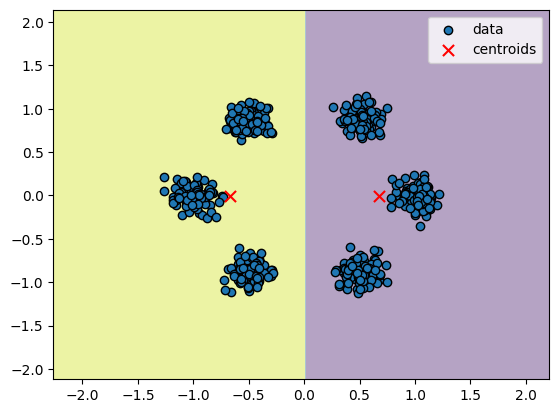

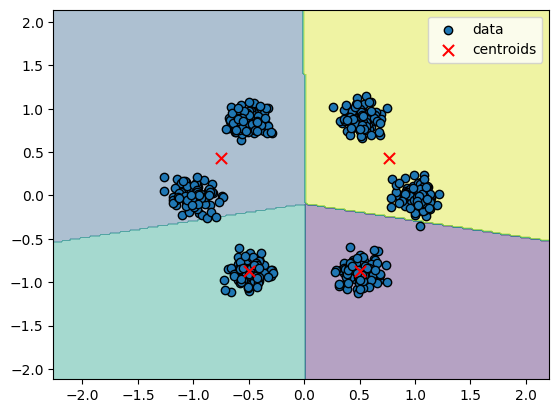

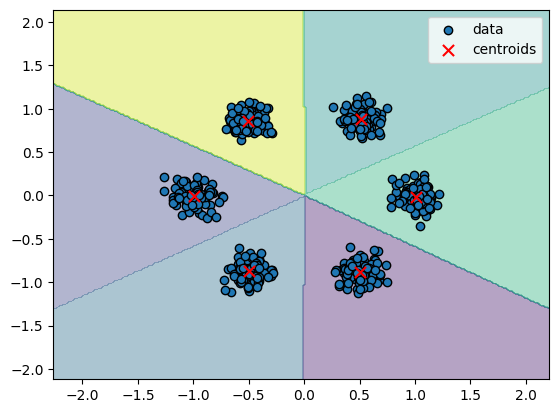

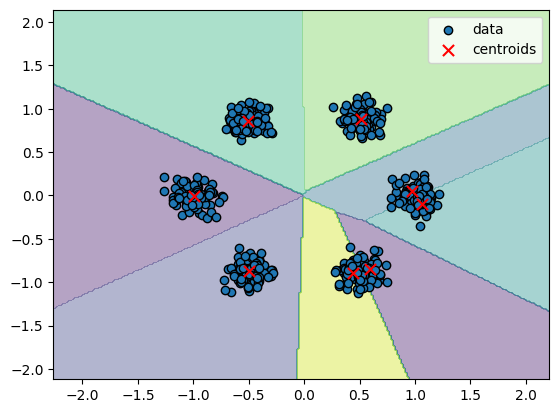

In [176]:
k_choices = [2, 4, 6, 8]

for k in k_choices:
    kmeans = KMeansClustering(k, init_strategy="random", random_state=seed)
    kmeans.fit(X)
    plot_decision_boundary(kmeans, X)


1. As k increases, centroid will be more closer in the cluster, 
2. With higher value of k, kmeans will overfit and divide existing cluster.

### Problem 2.2 (10 points):

In your implementation of `KMeansClustering`, you implemented two initialization strategies: random and k-means++. In this problem, you will see the effect that the initialization strategy can have on the resulting clusters. You will fit several `KMeansClustering` objects, each having the same number of clusters, but a different random seed -- thus, you will be simulating several initializations, and seeing their effect on the clusters.

- Fit a `KMeansClustering` object on `X` with 6 clusters for each fo the following values of `random_state = [5, 6, 7, 8]`. Use the initialization strategy `random`.
- For each of these random initializations, plot the resulting decision boundary using the provided function `plot_decision_boundary`.
- Include a short description (1-2 sentences) of what you see happen.

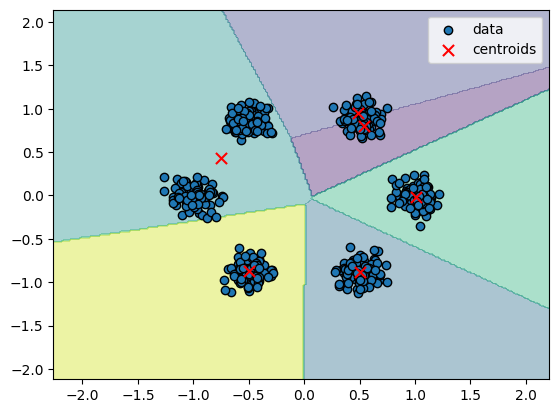

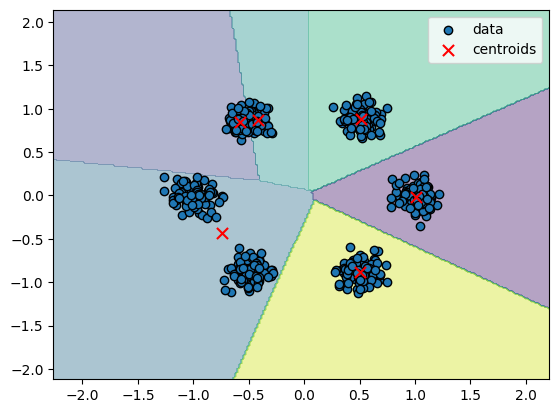

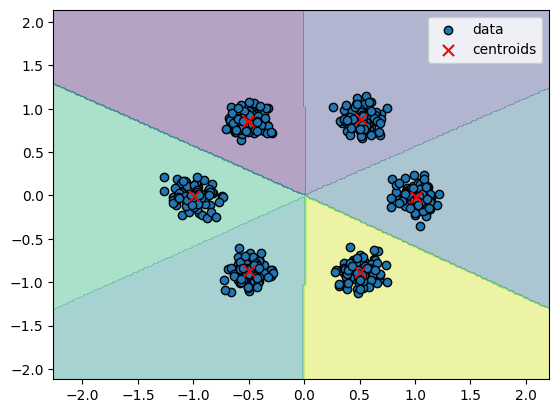

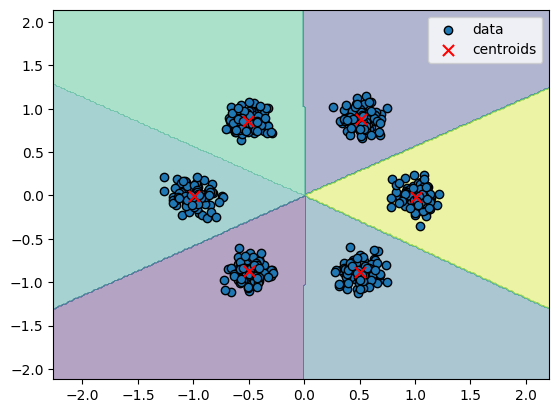

In [177]:
random_states = [5, 6, 7, 8]

for random_state in random_states:
    kmeans = KMeansClustering(6, "random", random_state=random_state)
    kmeans.fit(X)
    plot_decision_boundary(kmeans, X)

Different random_state can result some centroids dividing same cluster while others sitting in between two clusters. 

I assume this is because each random_state will cause np.random.choice() to produce different sets of centroids for only once, causing variety of decision boundaries.

### Problem 2.3 (10 points):

You will now do the same thing as in Problem 2.2, but with the k-means++ initialization strategy.

- Fit a `KMeansClustering` object on `X` with 6 clusters for each fo the following values of `random_state = [5, 6, 7, 8]`. Use the initialization strategy `kmeans++`.
- For each of these random initializations, plot the resulting decision boundary using the provided function `plot_decision_boundary`.
- Include a short description (1-2 sentences) of what you see happen. Be sure to compare your results with the initialization strategy `random` to your results with the initialization strategy `kmeans++`.

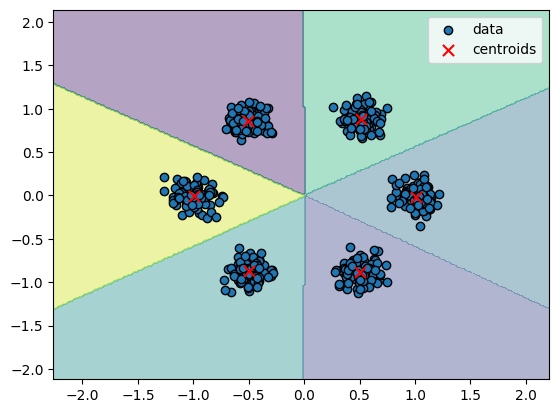

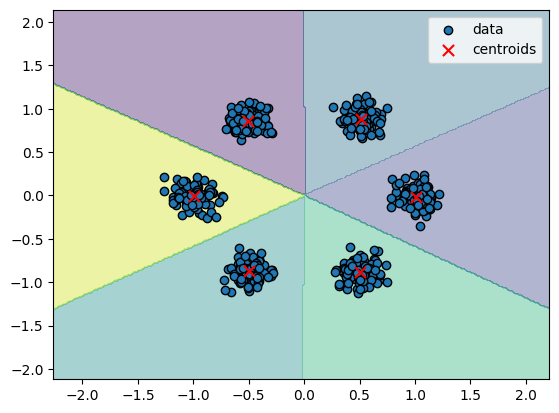

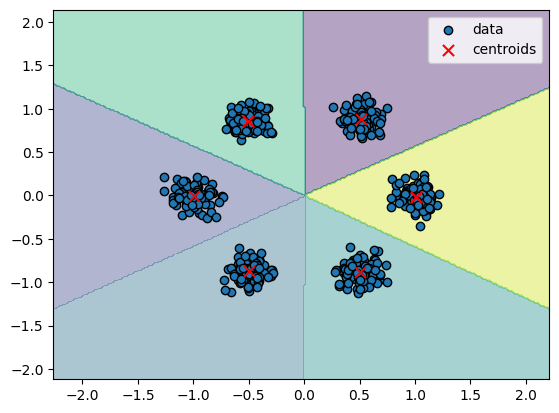

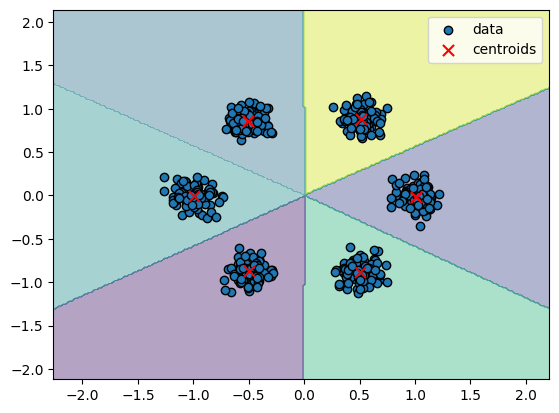

In [178]:
random_states = [5, 6, 7, 8]

for random_state in random_states:
    kmeans = KMeansClustering(6, "kmeans++", random_state=random_state)
    kmeans.fit(X)
    plot_decision_boundary(kmeans, X)

With kmeans++ strategy, all random states end up producing perfect KMeans clustering that seperates different clusters. 

Comparing to the "random" strategy, "kmeans++" use iterations to slowly pulls centroid into the cluster center. 

---
### Statement of Collaboration (5 points)

It is **mandatory** to include a Statement of Collaboration in each submission, with respect to the guidelines below. Include the names of everyone involved in the discussions (especially in-person ones), and what was discussed. If you did not collaborate with anyone, you should write something like "I completed this assignment without any collaboration."

All students are required to follow the academic honesty guidelines posted on the course website. For
programming assignments, in particular, I encourage the students to organize (perhaps using EdD) to
discuss the task descriptions, requirements, bugs in my code, and the relevant technical content before they start
working on it. However, you should not discuss the specific solutions, and, as a guiding principle, you are not
allowed to take anything written or drawn away from these discussions (i.e. no photographs of the blackboard,
written notes, referring to EdD, etc.). Especially after you have started working on the assignment, try
to restrict the discussion to EdD as much as possible, so that there is no doubt as to the extent of your
collaboration.

I completed the assignment without any collaboration.